In [159]:
import pandas as pd
import numpy as np
import sklearn.model_selection
from sklearn.metrics import r2_score
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

# Task 1
Read the historical Bitcoin prices from the provided csv file (btchistorical.csv) and describe the
properties of the dataframe.

In [142]:
# Import the Data
btc = pd.read_csv("btchistorical.csv", parse_dates=["date"])
btc.columns = [c.replace(' ', '_') for c in btc.columns]

In [143]:
# Summary statistics
btc.describe()

,open,close,volume,high,low,market_cap
count,3073.000000,3073.000000,3.073000e+03,3073.000000,3073.000000,3.073000e+03
mean,11300.065097,11308.630346,1.395598e+10,11595.863515,10972.396817,2.080593e+11
std,16243.433760,16242.872749,1.954176e+10,16665.300947,15758.625212,3.066943e+11
min,176.897003,178.102997,2.857830e+06,211.731003,171.509995,2.444379e+09
25%,581.650024,581.645020,5.780140e+07,589.151001,571.814026,7.737830e+09
50%,5271.746394,5279.348211,4.390020e+09,5363.257523,5169.283391,9.321830e+10
75%,10588.184021,10594.493354,2.432216e+10,10847.256993,10291.694493,1.893255e+11
max,67549.735581,67566.830088,3.509679e+11,68789.625939,66382.061008,1.274831e+12


# Task 2
Construct the following ten predictors/factors based on the provided formulas. Where you need to
calculate a factor that needs price, use the closing price.

In [144]:
btc["MCAP"] = np.log(btc.market_cap)
btc["PRC"] = np.log(btc.close)
btc["MAXDPRC"] = btc.close.rolling(7).apply(lambda x: np.max(x))
# Momentum
for i in range(1,5):
    btc[f"r_{i},0"] = btc.close.rolling(i*7).apply(lambda x: x.iloc[-1]-x.iloc[0])
# TODO Past one-to-four-week return
#btc["r_4,1"] = np.NAN
# ?same value for all datapoints. Should this be done using a rolling mehtod?
btc["PRCVOL"] = list(map(lambda x: np.log(np.average(x.volume)) * x.close.iloc[0], btc.rolling(7)))
btc["STDPRCVOL"] = np.log(np.std(btc.PRCVOL))
btc["DAMIHUD"] = btc.close.rolling(2).apply(lambda x: np.abs((x.iloc[-1]-x.iloc[0])/(x.iloc[0])))

# Task 3
Calculate seven day return based on the closing price using the following formula

In [156]:
btc["R7"] = btc.close.rolling(7).apply(lambda x: (x.iloc[-1]-x.iloc[0])/(x.iloc[0]))
btc.R7= btc.R7.shift(-7)
# Drop all rows with NaN
btc_cut = btc.dropna()

In [157]:
btc.head(10)

,date,open,close,volume,high,low,market_cap,MCAP,PRC,MAXDPRC,"r_1,0","r_2,0","r_3,0","r_4,0",PRCVOL,STDPRCVOL,DAMIHUD,R7
0,2014-01-01 23:59:59.999000+00:00,754.969971,771.400024,22489400.0,775.349976,754.969971,9.403308e+09,22.964327,6.648207,NaN,NaN,NaN,NaN,NaN,13058.687466,12.894559,NaN,0.050262
1,2014-01-02 23:59:59.999000+00:00,773.440002,802.390015,38489500.0,820.309998,767.210022,9.781074e+09,23.003715,6.687595,NaN,NaN,NaN,NaN,NaN,13293.452754,12.894559,0.040174,0.034371
2,2014-01-03 23:59:59.999000+00:00,802.849976,818.719971,37810100.0,834.150024,789.119995,9.980135e+09,23.023862,6.707742,NaN,NaN,NaN,NaN,NaN,13352.845350,12.894559,0.020352,0.010436
3,2014-01-04 23:59:59.999000+00:00,823.270020,859.510010,38005000.0,859.510010,801.669983,1.047736e+10,23.072483,6.756362,NaN,NaN,NaN,NaN,NaN,13382.010296,12.894559,0.049822,-0.020974
4,2014-01-05 23:59:59.999000+00:00,858.549988,933.530029,72898496.0,952.400024,854.520020,1.137966e+10,23.155093,6.838973,NaN,NaN,NaN,NaN,NaN,13539.393224,12.894559,0.086119,-0.094483
5,2014-01-06 23:59:59.999000+00:00,936.049988,953.289978,85565696.0,1017.119995,905.710022,1.162053e+10,23.176040,6.859919,NaN,NaN,NaN,NaN,NaN,13662.729667,12.894559,0.021167,0.048878
6,2014-01-07 23:59:59.999000+00:00,946.489990,802.000000,81311696.0,965.739990,802.000000,9.808300e+09,23.006495,6.687109,953.289978,30.599976,NaN,NaN,NaN,13731.463550,12.894559,0.158703,-0.011214
7,2014-01-08 23:59:59.999000+00:00,795.989990,842.719971,74175600.0,870.679993,776.179993,1.031036e+10,23.056415,6.736635,953.289978,40.329956,NaN,NaN,NaN,14386.308751,12.894559,0.050773,0.016579
8,2014-01-09 23:59:59.999000+00:00,841.469971,846.859985,59998600.0,864.359985,804.140015,1.036540e+10,23.061739,6.741535,953.289978,28.140015,NaN,NaN,NaN,14719.214578,12.894559,0.004913,-0.037825
9,2014-01-10 23:59:59.999000+00:00,846.690002,868.479980,31876800.0,871.190002,822.599976,1.063408e+10,23.087330,6.766745,953.289978,8.969971,NaN,NaN,NaN,15441.137094,12.894559,0.025530,-0.108660


# Task 4
Divide historical prices and volume (i.e., open, close, high, low, and volume) into training, validation, and testing samples and use linear regression, random forest, and support vector machine to investigate the performance of past prices for return prediction.

## Split Data

In [147]:
X = btc_cut[["open", "close", "high", "low", "volume"]]

## Linear Regression

Strong correlation --> only cosider "open" and "volume"

<AxesSubplot: >

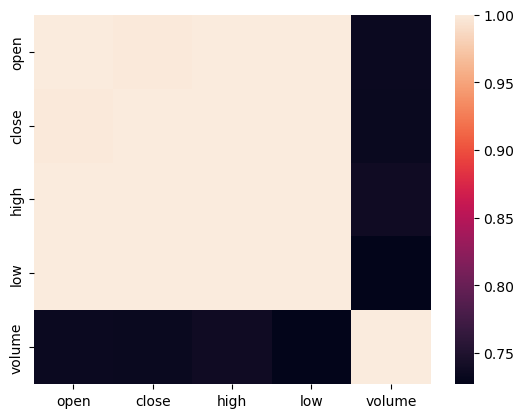

In [148]:
sns.heatmap(X.corr())

In [168]:
pred_vars = ["close", "open"]

X = btc_cut[pred_vars]
y = btc_cut.R7
# 80/20 split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

In [174]:
def lin_model(pred_vars:list):
    X = btc_cut[pred_vars]
    y = btc_cut.R7
    # 80/20 split
    X_train, X_test, y_train, y_test =\
        sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
    # Train
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train)
    fit = model.fit()
    #fit.summary()
    # Test
    X_test = sm.add_constant(X_test)
    pred = fit.predict(X_test)
    return r2_score(y_pred=pred, y_true=y_test), fit


def powerset(s):
    """Generator for all subsets of a given set
    Source:
        https://stackoverflow.com/questions/1482308/how-to-get-all-subsets-of-a-set-powerset

    Args:
         (list): set you want subsets of

    Yields:
        list: subset
    """
    x = len(s)
    masks = [1 << i for i in range(x)]
    for i in range(1 << x):
        yield [ss for mask, ss in zip(masks, s) if i & mask]


high = 0    
for set in powerset(["open", "close", "high", "low", "volume"]):
    r2, fit = lin_model(set)
    if r2 > high:
        high = r2
        best = fit
best.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     R7   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.429
Date:                Mon, 19 Dec 2022   Prob (F-statistic):             0.0635
Time:                        23:06:34   Log-Likelihood:                 2228.6
No. Observations:                2431   AIC:                            -4449.
Df Residuals:                    2427   BIC:                            -4426.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0150      0.002      6.281      0.000       0.010       0.020
open       -5.245e-06   4.55e-06     -1.152      0.249   -1.42e-05    3.68e-06
high        6.116e-06   4.25e-06      1.439      0.150   -2.22e-06    1.44e-05
low        -1.345e-06   3.27e-06     -0.412      0.680   -7.75e-06    5.06e-06
==============================================================================
Omnibus:                      192.382   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              562.198
Skew:                           0.409   Prob(JB):                    8.32e-123
Kurtosis:                       5.209   Cond. No.                     4.15e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [170]:
# Test
X_test = sm.add_constant(X_test)
pred = fit.predict(X_test)
r2_score(y_pred=pred, y_true=y_test)

0.004302373885870625

## Random Forest

## SVM